In [1]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
import shutil
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchvision.ops import box_iou
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [2]:
# Load the full annotations CSV
df = pd.read_csv("annotation_data/annotations.csv")

# Get unique image filenames
unique_images = df["image"].unique()

# Split into train/test image filenames
train_imgs, test_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
test_df = df[df["image"].isin(test_imgs)].reset_index(drop=True)

train_df.to_csv("annotation_data/train_annotations.csv", index=False)
test_df.to_csv("annotation_data/test_annotations.csv", index=False)

In [3]:
def copy_images(file_list, src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for fname in file_list:
        src = os.path.join(src_dir, fname)
        dest = os.path.join(dest_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dest)

copy_images(train_imgs, "Datasets/enhanced_images", "Datasets/train_images")
copy_images(test_imgs, "Datasets/enhanced_images", "Datasets/test_images")


In [4]:
class StarStreakDataset(Dataset):
    def __init__(self, csv_file, image_dir, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transforms = transforms

        # Map labels to integers
        self.label_map = {'star': 1, 'streak': 2}  # Add more if needed

        # Group annotations by image
        self.image_ids = self.df['image'].unique()
        self.image_data = self.df.groupby('image')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        records = self.image_data.get_group(img_id)

        img_path = os.path.join(self.image_dir, img_id)
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row['x_min']
            ymin = row['y_min']
            xmax = row['x_max']
            ymax = row['y_max']
            boxes.append([xmin, ymin, xmax, ymax])

            label = row['label']
            if isinstance(label, str):  # Convert string label to integer
                label = self.label_map[label.lower()]
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [5]:
train_dataset = StarStreakDataset(
    csv_file="annotation_data/train_annotations.csv",
    image_dir="Datasets/train_images",
    transforms=ToTensor()
)

test_dataset = StarStreakDataset(
    csv_file="annotation_data/test_annotations.csv",
    image_dir="Datasets/test_images",
    transforms=ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))
)

In [6]:
sample_img, sample_target = train_dataset[0]
print(sample_target)

{'boxes': tensor([[143., 101., 154., 113.],
        [146., 197., 160., 203.],
        [346., 381., 357., 393.],
        [521., 469., 533., 480.]]), 'labels': tensor([1, 2, 1, 1]), 'image_id': tensor([0])}


In [7]:
# Model Setup
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch} [Train]")

    for i, (images, targets) in progress_bar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        if i % print_freq == 0:
            progress_bar.set_postfix(loss=losses.item())

    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.train()  # set to train mode to get loss from model
    total_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc="Validation")

    with torch.no_grad():  # prevent gradient computation
        for i, (images, targets) in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            progress_bar.set_postfix(loss=losses.item())

    return total_loss / len(data_loader)


# Training Loop
def train_model(model, train_loader, test_loader, device, num_epochs=10, checkpoint_path='model_output/model_checkpoint.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
    writer = SummaryWriter()
    best_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 5
    log_df = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        val_loss = evaluate(model, test_loader, device)

        print(f"\nEpoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        log_df.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        pd.DataFrame(log_df).to_csv("training_log.csv", index=False)

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(" Best model saved.")
        else:
            patience_counter += 1
            print(f" No improvement. Patience: {patience_counter}/{early_stop_patience}")
            if patience_counter >= early_stop_patience:
                print(" Early stopping triggered.")
                break

    writer.close()

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=3)  # background, star, streak
model.to(device)

train_model(model, train_loader, test_loader, device, num_epochs=10)

c:\Users\NARINDER\Desktop\Intern_Assignments\Digantara\segment\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NARINDER\Desktop\Intern_Assignments\Digantara\segment\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 7/7 [00:12<00:00,  1.77s/it, loss=0.386]



Epoch 0, Train Loss: 1.2452, Validation Loss: 0.3800
 Best model saved.


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it, loss=0.259]



Epoch 1, Train Loss: 0.4949, Validation Loss: 0.2601
 Best model saved.


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it, loss=0.0904]



Epoch 2, Train Loss: 0.2788, Validation Loss: 0.0914
 Best model saved.


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it, loss=0.225]



Epoch 3, Train Loss: 0.2463, Validation Loss: 0.2229
 No improvement. Patience: 1/5


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.80s/it, loss=0.276]



Epoch 4, Train Loss: 0.2281, Validation Loss: 0.2780
 No improvement. Patience: 2/5


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it, loss=0.0984]



Epoch 5, Train Loss: 0.2306, Validation Loss: 0.1026
 No improvement. Patience: 3/5


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it, loss=0.0581]



Epoch 6, Train Loss: 0.1449, Validation Loss: 0.0664
 Best model saved.


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it, loss=0.0651]



Epoch 7, Train Loss: 0.1205, Validation Loss: 0.0678
 No improvement. Patience: 1/5


Validation: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it, loss=0.0621]



Epoch 8, Train Loss: 0.1157, Validation Loss: 0.0585
 Best model saved.


Validation: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it, loss=0.0448]


Epoch 9, Train Loss: 0.1025, Validation Loss: 0.0558
 Best model saved.


Detected Objects with Centroid Coordinates:
Star (Score: 0.99) -> Centroid: (x=351.51, y=387.08)
Star (Score: 0.98) -> Centroid: (x=148.30, y=106.74)
Star (Score: 0.98) -> Centroid: (x=527.03, y=474.39)
Streak (Score: 0.98) -> Centroid: (x=153.10, y=200.05)
Star (Score: 0.65) -> Centroid: (x=441.33, y=521.56)


c:\Users\NARINDER\Desktop\Intern_Assignments\Digantara\segment\Lib\site-packages\torchvision\utils.py:233: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


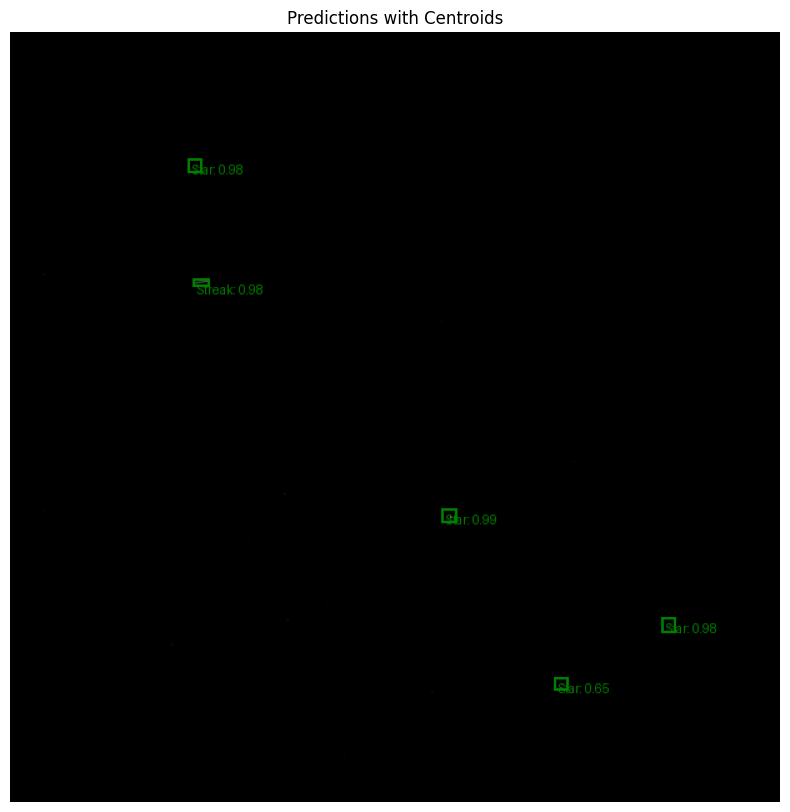

In [8]:
# Define label map
label_map = {1: 'Star', 2: 'Streak'}

# Transformation
transform = T.Compose([
    T.ToTensor()
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image), image

def get_centroids(boxes):
    """Compute centroids from bounding boxes."""
    centroids = []
    for box in boxes:
        x1, y1, x2, y2 = box
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        centroids.append((cx.item(), cy.item()))
    return centroids

def predict_centroids(model, image_path, device, threshold=0.5, visualize=True):
    model.eval()
    image_tensor, orig_image = load_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        prediction = model([image_tensor])[0]

    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']

    # Filter predictions
    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Calculate centroids
    centroids = get_centroids(boxes)

    # Print centroids with labels
    print("Detected Objects with Centroid Coordinates:")
    for i, (label, score, centroid) in enumerate(zip(labels, scores, centroids)):
        label_str = label_map.get(label.item(), f"Class {label.item()}")
        print(f"{label_str} (Score: {score.item():.2f}) -> Centroid: (x={centroid[0]:.2f}, y={centroid[1]:.2f})")

    # Optional: Visualize
    if visualize:
        label_texts = [f"{label_map[l.item()]}: {s.item():.2f}" for l, s in zip(labels, scores)]
        drawn_image = draw_bounding_boxes(
            (image_tensor * 255).byte().cpu(),
            boxes=boxes.cpu(),
            labels=label_texts,
            colors="green",
            width=2,
            font_size=20
        )
        plt.figure(figsize=(10, 10))
        plt.imshow(drawn_image.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Predictions with Centroids")
        plt.show()

    return centroids

# Usage
image_path = "Datasets/train_images/Raw_Observation_001_Set1_enhanced_plot.png"
model.load_state_dict(torch.load("model_output/model_checkpoint.pth", map_location=device))
centroids = predict_centroids(model, image_path, device)


In [9]:
def compute_detection_accuracy(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    for images, targets in tqdm(data_loader, desc="Evaluating Accuracy"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images)

        for pred, target in zip(outputs, targets):
            pred_boxes = pred['boxes']
            pred_labels = pred['labels']
            pred_scores = pred['scores']

            true_boxes = target['boxes']
            true_labels = target['labels']

            if len(pred_boxes) == 0 or len(true_boxes) == 0:
                continue

            ious = box_iou(pred_boxes, true_boxes)

            for i, (box, label) in enumerate(zip(pred_boxes, pred_labels)):
                max_iou, max_idx = ious[i].max(0)
                if max_iou >= iou_threshold and label == true_labels[max_idx]:
                    correct += 1
                total += 1

    accuracy = correct / total if total > 0 else 0
    print(f"Detection Accuracy: {accuracy*100:.2f}% ({correct}/{total})")
    return accuracy


In [10]:
train_acc = compute_detection_accuracy(model, train_loader, device)
test_acc = compute_detection_accuracy(model, test_loader, device)

Evaluating Accuracy: 100%|██████████| 28/28 [00:52<00:00,  1.86s/it]


Detection Accuracy: 61.86% (193/312)


Evaluating Accuracy: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]

Detection Accuracy: 66.67% (42/63)


In [11]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(